FileUpload(value={}, accept='.xlsx', description='Upload')

Button(description='Read File', style=ButtonStyle())

<IPython.core.display.Javascript object>


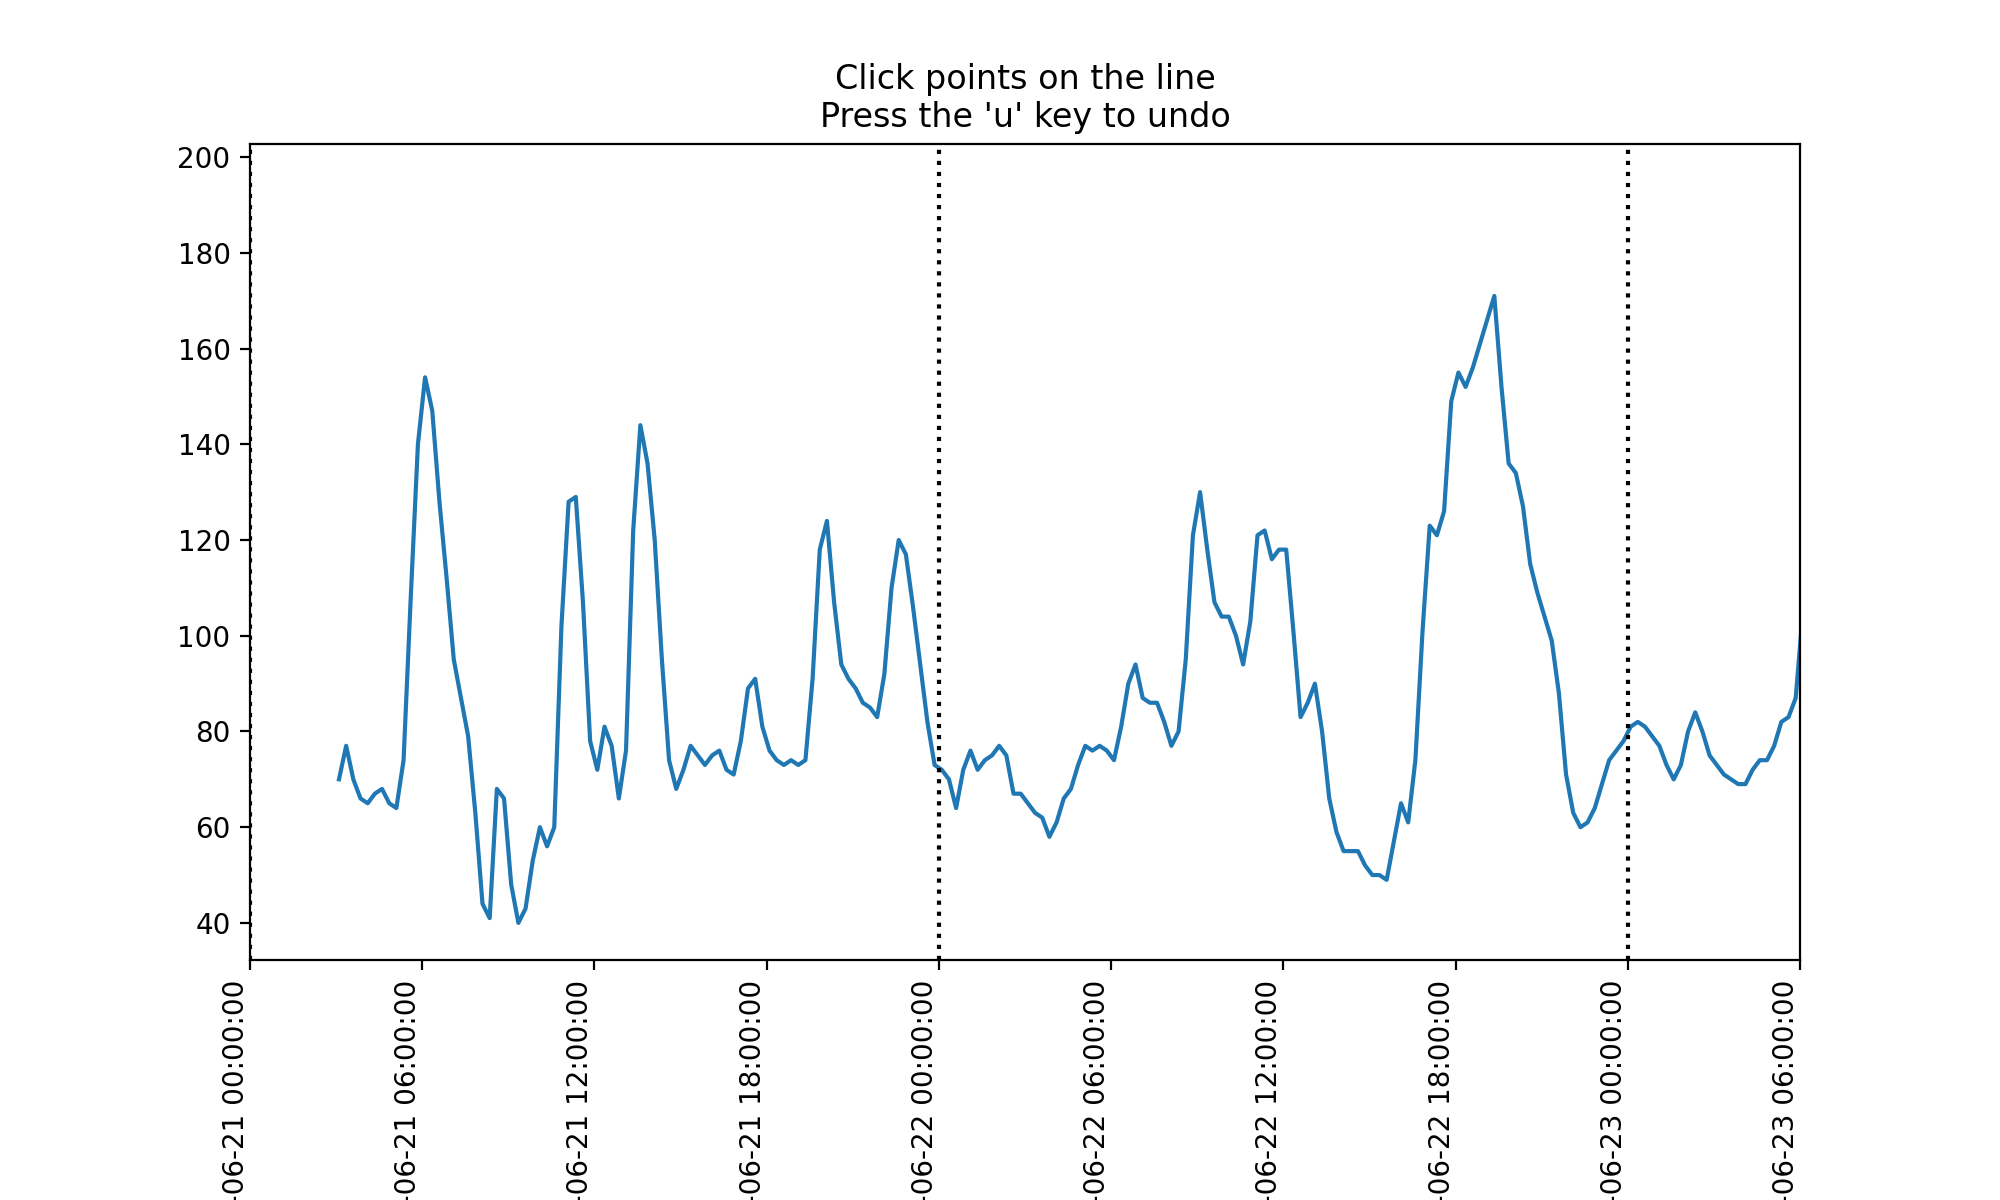

FloatRangeSlider(value=(1.0, 2.0), description='Days Range:', layout=Layout(width='100%'), max=37.0, min=1.0, …

Dropdown(description='Label:', options=('Start meal', 'Peak', 'End meal'), value='Start meal')

Dropdown(description='Certainty:', options=('yes', 'no'), value='yes')

Button(description='Save File', style=ButtonStyle())

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import tkinter as tk
from tkinter import filedialog

def upload_file():
    file_path_widget = widgets.FileUpload(accept='.xlsx')  # File upload widget
    display(file_path_widget)

    def read_excel_file(btn):
        if file_path_widget.value:
            uploaded_file = file_path_widget.value[next(iter(file_path_widget.value))]  # Get the uploaded file
            # Read Excel file
            excel_data = pd.read_excel(uploaded_file['content'])
            time_column = 'Timestamp'
            glucose_column = 'Glucose'

            if time_column in excel_data.columns and glucose_column in excel_data.columns:
                time_values = excel_data[time_column].tolist()
                data = excel_data[glucose_column].tolist()

                # Convert time_values to datetime objects
                time_stamps = pd.to_datetime(time_values)

                # Create empty lists to store clicked coordinates and labels
                clicked_x = []
                clicked_y = []
                labels = []
                certain_list = []
                annotations = []

                def on_pick(event):
                    if event.mouseevent.button == 1:  # Check if left mouse button was clicked
                        if event.artist == lines[0]:
                            clicked_x.append(event.mouseevent.xdata)
                            clicked_y.append(event.mouseevent.ydata)
                            label = dropdown1.value  # Get the selected label from the dropdown menu
                            labels.append(label)
                            certain = dropdown2.value
                            certain_list.append(certain)
                            print(f"Clicked: x={event.mouseevent.xdata:.2f}, y={event.mouseevent.ydata:.2f}")
                            color = 'red' if label == 'Start meal' else 'blue' if label == 'Peak' else 'green'
                            marker = 'o' if certain == 'yes' else '*'
                            point, = ax.plot(event.mouseevent.xdata, event.mouseevent.ydata, marker=marker, color=color)  # Plot clicked point
                            annotate = annotate_point(label, event.mouseevent.xdata, event.mouseevent.ydata)  # Annotate the point
                            annotations.append((point, annotate))
                            fig.canvas.draw()  # Update the figure
                            
                def undo_last_click(event):
                    if event.key == 'u':
                        if len(clicked_x) > 0:
                            clicked_x.pop()
                            clicked_y.pop()
                            labels.pop()
                            certain_list.pop()
                            point, annotate = annotations.pop()  # Remove the last plotted point and its annotation
                            point.remove()
                            annotate.remove()
                            fig.canvas.draw()  # Update the figure

                def save_file(btn):
                    root = tk.Tk()
                    root.withdraw()

                    file_path = filedialog.asksaveasfilename(defaultextension='.xlsx')
                    if file_path:
                        timestamps = [mdates.num2date(x) for x in clicked_x]  # Convert numeric timestamps back to the original format
                        formatted_timestamps = [timestamp.strftime('%Y-%m-%d %H:%M:%S') for timestamp in timestamps]  # Format the timestamps as desired

                        df = pd.DataFrame({'timestamp': formatted_timestamps, 'glucose': clicked_y, 'label': labels, 'certainty': certain_list})
                        df = df.sort_values('timestamp')
                        df.to_excel(file_path, index=False)
                        print("Clicked points saved successfully")

                def annotate_point(label, x, y):
                    return ax.annotate(label, (x, y), textcoords="offset points", xytext=(0, 10),
                                ha='center', fontsize=8, color='black')

                fig, ax = plt.subplots(figsize=(10, 6))
                lines = ax.plot(time_stamps, data)
                ax.set_title("Click points on the line\nPress the 'u' key to undo")

                # Format the x-axis as time stamps
                date_format = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
                ax.xaxis.set_major_formatter(date_format)
                fig.autofmt_xdate(rotation=90)

                # Enable picking on the line
                lines[0].set_picker(True)

                # Connect the on_pick event to the figure
                cid_pick = fig.canvas.mpl_connect('pick_event', on_pick)

                # Connect the undo_last_click event to the figure
                cid_undo = fig.canvas.mpl_connect('key_press_event', undo_last_click)

                dropdown1_options = ['Start meal','Peak','End meal']
                dropdown1 = widgets.Dropdown(options=dropdown1_options, description='Label:')
                dropdown2_options = ['yes', 'no']
                dropdown2 = widgets.Dropdown(options=dropdown2_options, description='Certainty:')
                save_path_btn = widgets.Button(description='Save File')
                save_path_btn.on_click(save_file)


                # Find unique dates in the timestamps
                unique_dates = pd.Series(time_stamps).dt.date.unique()

                # Add vertical black dotted lines at the first timestamp of each date
                for date in unique_dates:
                    first_timestamp = pd.to_datetime(str(date))
                    ax.axvline(first_timestamp, linestyle='dotted', color='black')

                def update_time_range(change):
                    start_day = float(change.new[0])
                    end_day = float(change.new[1])
                    # Calculate the start and end timestamps based on the selected range of days
                    start_timestamp = pd.to_datetime(str(unique_dates[0])) + pd.DateOffset(days=start_day-1)
                    end_timestamp = pd.to_datetime(str(unique_dates[0])) + pd.DateOffset(days=end_day)  # Extend to the first timestamp of the next day
                    ax.set_xlim(start_timestamp, end_timestamp)
                    fig.canvas.draw()

                # Create the slider widget for selecting the time range
                slider = widgets.FloatRangeSlider(
                    min=1,  
                    max=(time_stamps[-1] - time_stamps[0]).days + 1,  # Maximum value of the slider is the initial end day
                    step=0.25,  
                    value=[1,2],  # Initial range of the slider (first day to next day)
                    description='Days Range:',
                    continuous_update=True,
                    layout=widgets.Layout(width='100%') 
                )
                
                slider.observe(update_time_range, 'value')

                display(slider)
                display(dropdown1)
                display(dropdown2)
                display(save_path_btn)
                
                # Set the initial x-axis limits to the first day
                start_date = unique_dates[0]
                start_timestamp = pd.to_datetime(str(start_date))
                end_timestamp = start_timestamp + pd.DateOffset(days=1)
                ax.set_xlim(start_timestamp, end_timestamp)

                plt.show()


    read_excel_btn = widgets.Button(description='Read File')
    read_excel_btn.on_click(read_excel_file)
    display(read_excel_btn)


upload_file()